## Task1:代码复现

### 绘制序列

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import random
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
# 绘制序列
def plot_series(time, series, format="-", start=0, end=None, label=None):
    # 根据时间轴和对应数据列表绘制序列图
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # 设置图例说明字体大小
    if label:
        plt.legend(fontsize=14)
    # 设置网格线
    plt.grid(True)

### 时序数据生成

趋势模式的生成函数

In [4]:
def trend(time, slope=0):
    # 线性趋势
    return slope * time # 使用slope控制上升 or 下降

噪声模式的生成函数

In [5]:
def white_noise(time, noise_level=1, seed=None):
    # 白噪声
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level # noise_level控制噪声幅度

季节性模式的生成函数

In [6]:
def seasonal_pattern(season_time):
    # 分段函数
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
# 将时间序列映射到0-1之间
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

上升趋势的生成

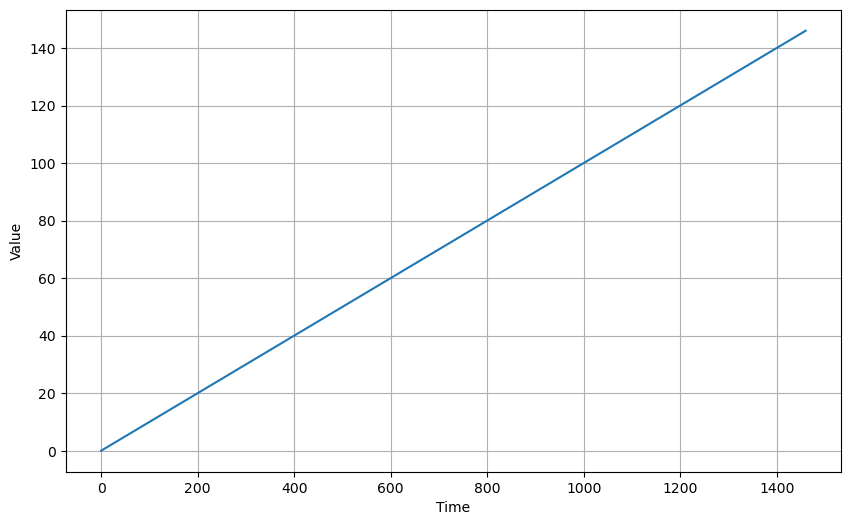

In [7]:
time = np.arange(4 * 365 + 1) # 生成4年的数据
series = trend(time, 0.1) # 生成线性趋势
plt.figure(figsize=(10, 6))
plot_series(time, series)

季节性的生成

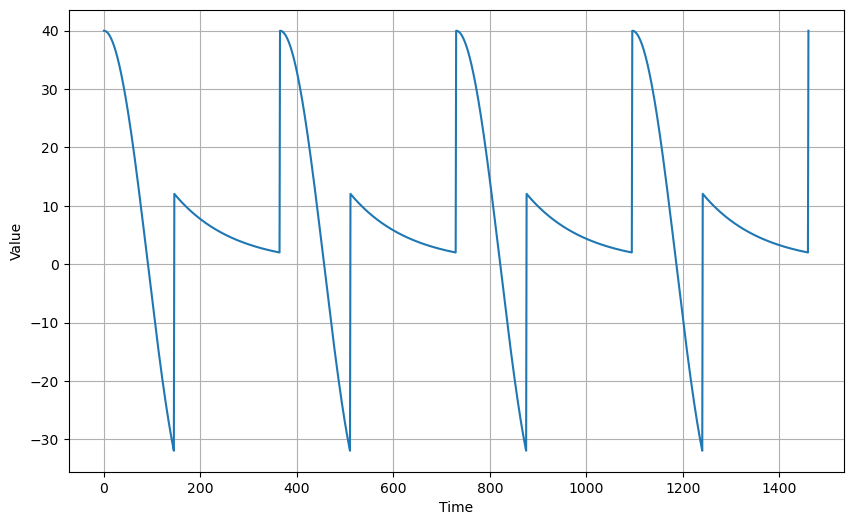

In [8]:
# 设置幅值
amplitude = 40
# 生成季节性数据
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)

白噪声的生成

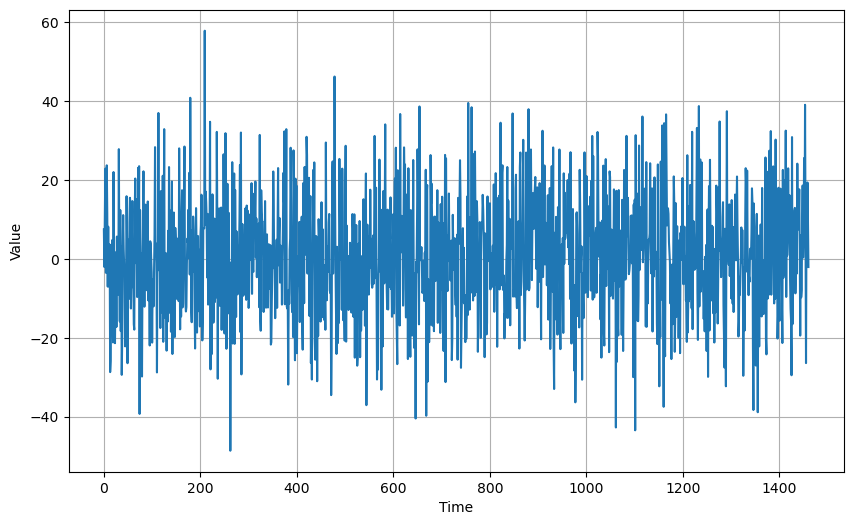

In [9]:
# 设置噪声幅度
noise_level = 15

noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)

趋势+季节性的叠加

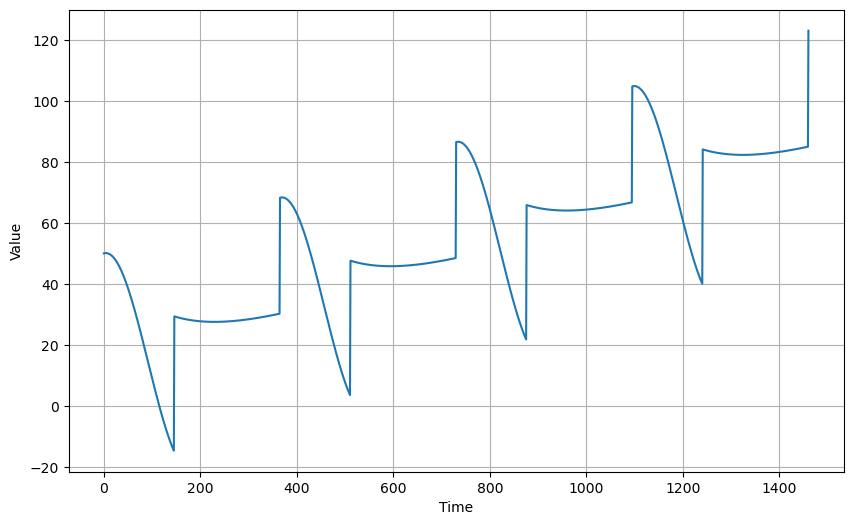

In [10]:
# 基础序列+上升趋势+季节性
slope = 0.05
baseline = 10
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)

趋势+季节性+白噪声

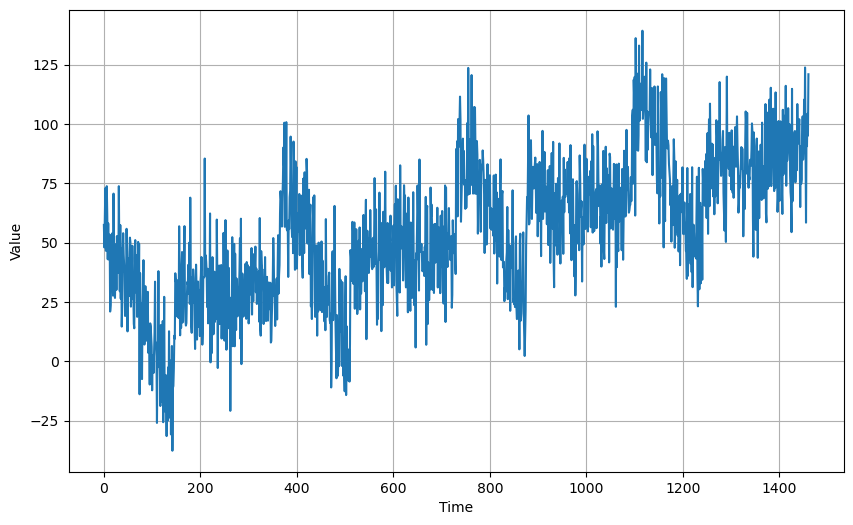

In [11]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)

### 数据处理

1. 划分训练集、测试集

In [12]:
def train_test_split(series, split_prop):
    train = series[:int(split_prop * int(series.size))]
    test = series[int(split_prop * int(series.size)):]
    return train, test

2. 滑窗、划分特征/标签函数

In [13]:
def data_process(train, test, window_size):
    # 将数据转为tensor并滑窗，得到短序列
    train_tensor = torch.from_numpy(train)
    train_window_split = train_tensor.unfold(0, window_size, 1)
    train_set = train_window_split.numpy()
     
    test_tensor = torch.from_numpy(test)
    test_window_split = test_tensor.unfold(0, window_size, 1)
    test_set = test_window_split.numpy()
    
    # 打乱训练集短序列数据
    train_templ = train_set.tolist()
    random.shuffle(train_templ)
    train_templ2 = np.array(train_templ)
    
    # 将短序列划分为feature和label
    train_feature_array = train_templ2[:, :window_size-1]
    train_label_array = train_templ2[:, window_size-1:]
    test_feature_array = test_set[:, :window_size-1]
    test_label_array = test_set[:, window_size-1:]
    # 转为tensor
    train_feature = torch.from_numpy(train_feature_array)
    train_label_temp = torch.from_numpy(train_label_array)
    test_feature = torch.from_numpy(test_feature_array)
    test_label_temp = torch.from_numpy(test_label_array)
    
    # 将label张量降维，去除维度为1的维度
    train_label = train_label_temp.squeeze()
    test_label = test_label_temp.squeeze()
    
    return train_feature, train_label, test_feature, test_label

3. 划分batch函数

In [14]:
# 将数据划分为指定大小的batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        # 最后一次可能不足一个batch
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) 
        yield  features.index_select(0, j), labels.index_select(0, j)

4. 设置划分比例进行划分，设置滑窗大小将长序列变为短序列、划分特征与标签等

In [15]:
split_prop = 0.7
train, test = train_test_split(series, split_prop)
window_size = 6
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

torch.Size([1022])
torch.Size([1017, 5])
torch.Size([1017])
torch.Size([434, 5])
torch.Size([434])


### 神经网络

1. 生成混合模式的时序数据

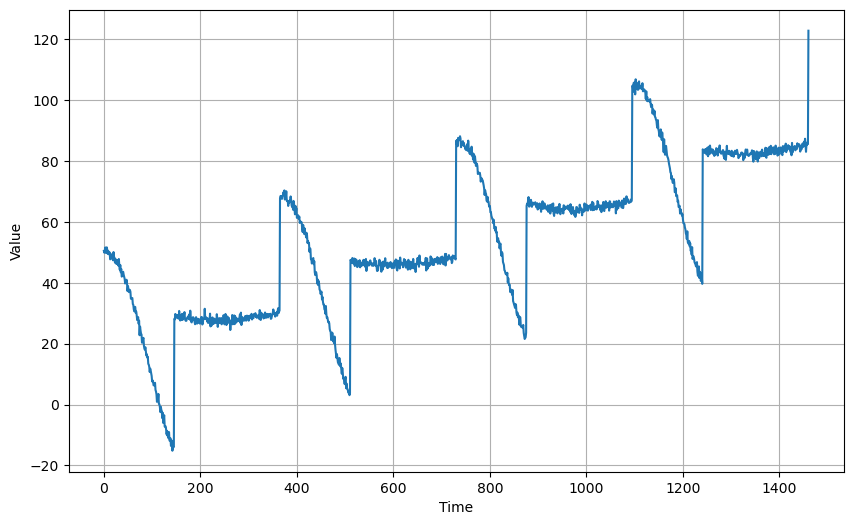

In [15]:
time = np.arange(4 * 365 + 1)
baseline = 10
slope = 0.05
amplitude = 40
noise_level = 1
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)

2. 数据处理

In [16]:
split_prop = 0.7
train, test = train_test_split(series, split_prop)
window_size = 6
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

torch.Size([1017, 5])
torch.Size([1017])
torch.Size([434, 5])
torch.Size([434])


3. 构建三层前馈神经网络

In [17]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)
    
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 5, 1, 3

# 定义模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

3. 构建三层前馈神经网络

In [18]:
# 损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / (y.shape[0])

In [19]:
# 参数初始化
for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    
lr = 0.01
num_epochs = 200
batch_size = 128
loss = squared_loss
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # Adam优化器

4. 训练模型

In [20]:
train_loss = []
test_loss = []

# 模型训练
for epoch in range(num_epochs): # 外循环训练一轮
    train_l, test_l = 0.0, 0.0
    for X,y in data_iter(batch_size, train_feature, train_label): # 内循环训练一个batch
        y_hat = net(X)
        l = loss(y_hat, y).sum()
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        # 反向传播
        l.backward()
        # 更新参数
        optimizer.step()
        
    # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）
    train_l = loss(net(train_feature), train_label).mean().item()
    test_l = loss(net(test_feature), test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))
    

epoch 0, train loss 1.895518, test loss 12.579772
epoch 1, train loss 1.104858, test loss 7.332727
epoch 2, train loss 0.238381, test loss 1.546884
epoch 3, train loss 0.053241, test loss 0.242744
epoch 4, train loss 0.107328, test loss 0.586383
epoch 5, train loss 0.019871, test loss 0.048782
epoch 6, train loss 0.035635, test loss 0.171847
epoch 7, train loss 0.022171, test loss 0.073405
epoch 8, train loss 0.021301, test loss 0.055534
epoch 9, train loss 0.020315, test loss 0.051196
epoch 10, train loss 0.019516, test loss 0.052487
epoch 11, train loss 0.019466, test loss 0.052371
epoch 12, train loss 0.019231, test loss 0.048266
epoch 13, train loss 0.019189, test loss 0.048124
epoch 14, train loss 0.019100, test loss 0.049032
epoch 15, train loss 0.019047, test loss 0.048875
epoch 16, train loss 0.018990, test loss 0.048178
epoch 17, train loss 0.018933, test loss 0.048140
epoch 18, train loss 0.018876, test loss 0.048247
epoch 19, train loss 0.018817, test loss 0.048029
epoch 20,

5. 绘制损失函数Loss曲线

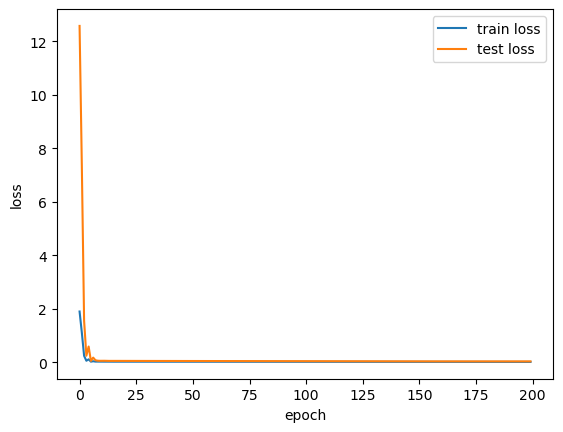

In [21]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

6. 预测并对比

In [22]:
# 预测函数
def predict(x):
    temp = torch.from_numpy(x)
    print('temp:', temp.shape)
    x_tensor = temp.reshape(1, 1, window_size-1) #(batch_size, channel, feature_size)
    print('x_tensor:', x_tensor.shape)
    return net(x_tensor)

temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tensor: torch.Size([1, 1, 5])
temp: torch.Size([5])
x_tens

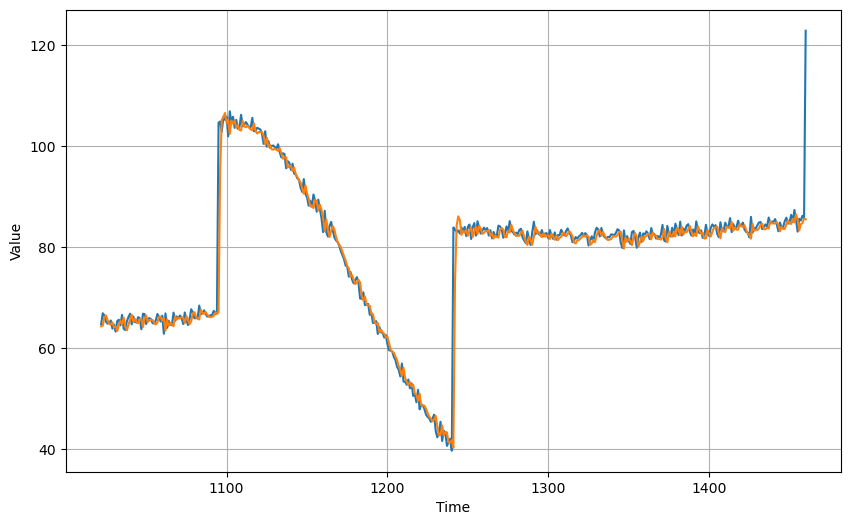

In [24]:
test_predict = []
split_point = int(split_prop * int(series.size))
# 针对测试集中的数据，按照滑窗大小取出特征，利用训练好的网络预测下一个值
for i in range((split_point - (window_size-1)), (series.size - (window_size-1))):
    x = series[i:(i + window_size-1)]
    y = predict(x)
    y = y.detach().numpy().squeeze()
    test_predict.append(y)
# 将测试集真实数据与网络预测数据以不同颜色绘制在一起，便于对比
test_time = time[split_point:]
plt.figure(figsize=(10, 6))
plot_series(test_time, test)
plot_series(test_time, test_predict)